In [1]:
import gpjax as gpx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from gpjax.utils import dict_array_coercion
from pprint import PrettyPrinter
pp=PrettyPrinter(indent=4)

key = jr.PRNGKey(123)

2022-02-07 15:31:56.994867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Simulate some data

In this tutorial we'll be trying to model the normalised sinc function
$$f(x) = \frac{\sin(\pi x)}{\pi x}$$
for $x\in\mathbb{R}$ where $x\neq 0 $.

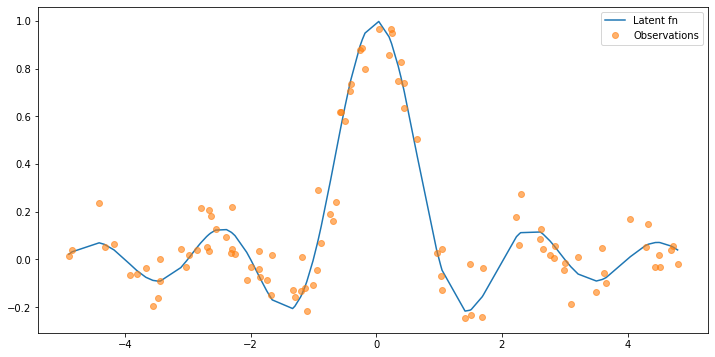

In [2]:
N = 100
noise = 0.1

x = jnp.sort(jr.uniform(key, minval=-5.0, maxval=5.0, shape=(N, 1)), axis=0)
f = lambda x: jnp.sin(jnp.pi * x) / (jnp.pi * x)
y = f(x) + jr.normal(key, shape=x.shape) * noise

fig, ax  = plt.subplots(figsize=(12, 6))
ax.plot(x, f(x), label="Latent fn")
ax.plot(x, y, "o", label="Observations", alpha=0.6)
ax.legend(loc="best")

## Define GPJax objects

We'll now wrap this pair of observed data arrays up into a `Dataset` object and define a 'GP' posterior object.

In [3]:
training = gpx.Dataset(X=x, y=y)
posterior = gpx.Prior(kernel=gpx.RBF()) * gpx.Gaussian(num_datapoints=training.n)

## Initialise parameters

All parameters in this model are constrained to be positive. Our MCMC sampler will therefore sample on the parameters' unconstrained space and the samples will then be back transformed onto the original positive real line. GPJax's `initialise` function makes this straightforward.

In [4]:
params, constrainers, unconstrainers = gpx.initialise(posterior)

#### Parameter type

To use the MCMC samplers supplied with TensorFlow probability we must supply our parameters as an array. This is at odds with GPJax where parameters are stored in dictionaries. We therefore use the `dict_array_coercion` function that returns two functions: one that maps from an array to a dictionary, and a second that maps back to an array given a dictionary. These functions are order preserving.

In [5]:
dict_to_array, array_to_dict = dict_array_coercion(params)

In [6]:
parray = dict_to_array(params)
print(parray)

[DeviceArray([1.], dtype=float64), DeviceArray([1.], dtype=float64), DeviceArray([1.], dtype=float64)]


In [7]:
array_to_dict(parray) == params

True

### Specifying priors

We'll now place Gamma priors down on our parameters. In GPJax, this is done using TensorFlow Probability's `Distributions` module.

In [8]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

priors = gpx.parameters.copy_dict_structure(params)
priors['kernel']['lengthscale'] = tfd.Gamma(concentration=jnp.array(1.), rate=jnp.array(1.))
priors['kernel']['variance'] = tfd.Gamma(concentration=jnp.array(1.), rate=jnp.array(1.))
priors['likelihood']['obs_noise'] = tfd.Gamma(concentration=jnp.array(1.), rate=jnp.array(1.))

{'kernel': {'lengthscale': <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float64>,
  'variance': <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float64>},
 'likelihood': {'obs_noise': <tfp.distributions.Gamma 'Gamma' batch_shape=[] event_shape=[] dtype=float64>},
 'mean_function': {}}

### Defining our target function

We'll now define the target distribution that our MCMC sampler will sample from. For our GP, this is the marginal log-likelihood that we will specify in the following way.

In [16]:
mll = posterior.marginal_log_likelihood(training, constrainers,priors=priors, negative=False)
mll(params)

DeviceArray(-119.66311476, dtype=float64)

As our model parameters are now an array, not a dictionary, we must define a small function that maps the array back to a dictionary and then evaluates the marginal log-likelihood. Using the second return of `dict_array_coercion` this is easy to do as follows. 

In [10]:
def build_log_pi(target, mapper_fn):
    def array_mll(parameter_array):
        parameter_dict = mapper_fn([jnp.array(i) for i in parameter_array])
        return target(parameter_dict)
    return array_mll

mll_array_form = build_log_pi(mll, array_to_dict)

## Sample

We now have all the necessary machinery in place to sample from our target distribution. We'll use TensorFlow's Hamiltonian Monte-Carlo sampler equipped with the No U-Turn Sampler kernel. We'll draw 2500 samples from our target distribution for illustrative purposes. In practice, you may wish to sample more though.

In [45]:
n_samples = 2500

def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(mll_array_form, 1e-1)
    return tfp.mcmc.sample_chain(
        n_samples,
        current_state=state,
        kernel=kernel,
        trace_fn=lambda _, results: results.target_log_prob,
        seed=key,
    )

Everything is pure Jax, so we are free to JIT compile our sampling function and go.

In [46]:
states, log_probs = jax.jit(run_chain)(key, jnp.array(dict_to_array(params)))

## Inspecting samples

We'll now assess the quality of our chains. We'll discard the first 500 samples as the sampler may not have yet reached the stationary distribution. We'll also thin the chains by keeping every third sample. This reduces the autocorrelation present in the samples.

In [47]:
burn_in = 500
thin_factor = 3
n_params = states.shape[1]

samples = [states[burn_in:, i, :][::thin_factor] for i in range(n_params)]
sample_dict = array_to_dict(samples)
constrained_samples = gpx.transform(sample_dict, constrainers)
constrained_sample_list = dict_to_array(constrained_samples)

We'll now plot our samples

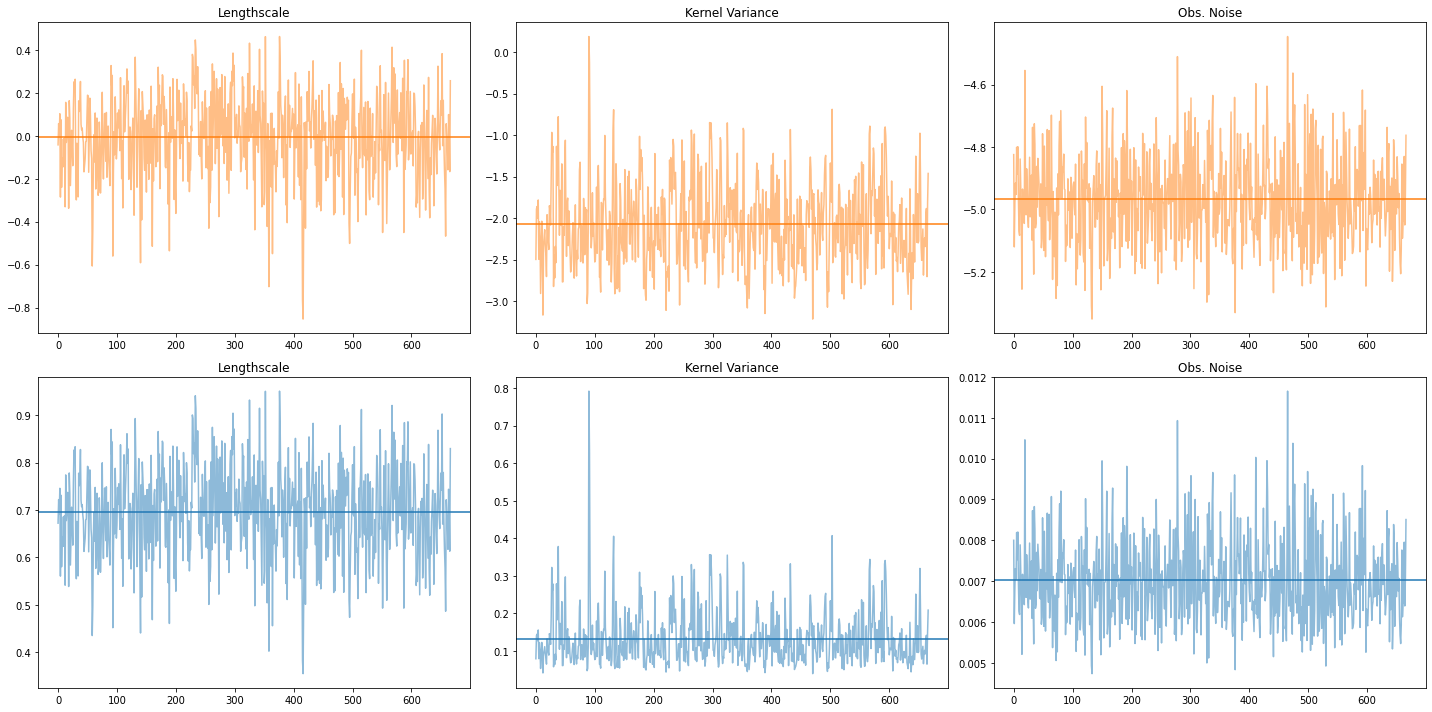

In [49]:
fig, axes = plt.subplots(figsize=(20, 10), ncols=n_params, nrows=2)
titles = ['Lengthscale', 'Kernel Variance', 'Obs. Noise']

for i in range(n_params):
    axes[0, i].plot(samples[i], alpha=0.5, color='tab:orange')
    axes[1, i].plot(constrained_sample_list[i], alpha=0.5, color='tab:blue')
    axes[0, i].axhline(y = jnp.mean(samples[i]), color='tab:orange')
    axes[1, i].axhline(y = jnp.mean(constrained_sample_list[i]), color='tab:blue')
    axes[0, i].set_title(titles[i])
    axes[1, i].set_title(titles[i])

plt.tight_layout()

## Making predictions

We'll now use the samples for prediction. For now, we'll just use the expected parameter value for prediction but you may wish to draw a few samples from the GP posterior for each sample collected during the MCMC sampling phase.

In [55]:
xtest = jnp.linspace(-5.2, 5.2, 500).reshape(-1, 1)
learned_params = array_to_dict([jnp.mean(i) for i in constrained_sample_list])

mu = posterior.mean(training, learned_params)(xtest)
sigma = posterior.variance(training, learned_params)(xtest)
one_stddev = jnp.sqrt(jnp.diag(sigma))

We'll now plot the learned posterior predictive distribution evaluated at the above defined test points.

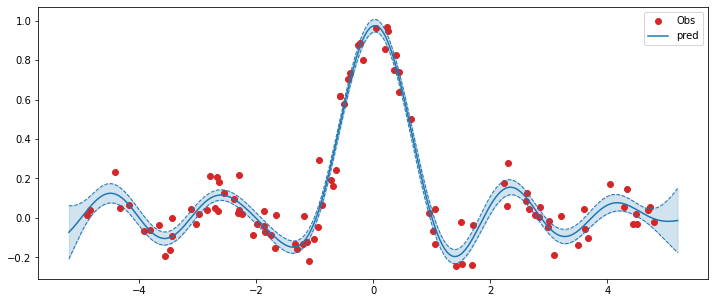

In [56]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, 'o', label='Obs', color='tab:red')
ax.plot(xtest, mu, label='pred', color='tab:blue')
ax.fill_between(xtest.squeeze(), mu.squeeze()-one_stddev, mu.squeeze() + one_stddev, alpha=0.2, color='tab:blue')
ax.plot(xtest, mu.squeeze()-one_stddev, color='tab:blue', linestyle='--', linewidth=1)
ax.plot(xtest, mu.squeeze()+one_stddev, color='tab:blue', linestyle='--', linewidth=1)

ax.legend()

Things look good, so this concludes our tutorial on interfacing TensorFlow Probability with GPJax. There are a large number of samples present within TensorFlow probability and the workflow demonstrated here only just scratches the surface regarding the inference that is possible with TensorFlow probability.

## System Configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder"